In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Use this command if you didn't save your credentials:
service = QiskitRuntimeService(channel="ibm_quantum", token="63fe2dff151a1fa50f67b735e09f867d6a2b0380862c050ddac3bdb597586e4818b7a86afe0861d76d84be7f577561808c6a540f48dfb40f6406c056abf86e4c")

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit import Aer
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit import Parameter
from qiskit import transpile
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
import itertools as it
import copy
import stomp_functions as stf
from qiskit.quantum_info import random_clifford
import time
from qiskit.providers.fake_provider import FakeBelem
from qiskit_ibm_runtime import Estimator, Sampler, Options
from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import HGate
from qiskit_aer.noise import NoiseModel

In [3]:
def create_H(N, g, j):
    z_ops, x_ops = stf.construct_op_lists(N)
    
    # Construct the Hamiltonian
    # Loop over sites to construct parts of H
    H_qis = 0
    for n in range(N-1):
        H_qis += -j * z_ops[n] @ z_ops[n+1]
        for m in range(N):
            H_qis += -j * g * x_ops[n]

    return H_qis

In [4]:
def get_coeffs_and_obs(A):
    paulis = stf.pauli_string_decomp(A, 2)
    coeffs = []
    obs_list = []
    for key in paulis:
        if np.abs(paulis[key]) != 0:
            coeffs.append(paulis[key])
            obs_list.append(Pauli(key))
    
    return np.array(coeffs), obs_list

In [5]:
def expt_estimator(qr, H, num_steps, cliff, estimator_options):
    backend = service.backend("ibmq_qasm_simulator")
    estimator = Estimator(backend=backend, options=estimator_options)
    
    # Create initial circuit for appending into lists
    circ = QuantumCircuit(qr)
    circ.append(cliff, qr)
    
    # Create lists for storing expectation values
    U_sq_expt_vals = []
    Ud_sq_expt_vals = []
    HU_sq_expt_vals = []
    HUd_sq_expt_vals = []
    
    for n in range(num_steps):
        # Create U^2 and get coefficients and observables for pauli string decomposition
        U_sq = (-float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
        U_sq_coeffs, U_sq_obs_list = get_coeffs_and_obs(U_sq)
        
        # Create list of circuits for U_sq and then run using estimator
        U_sq_circs = [circ for _ in U_sq_coeffs]
        U_sq_job = estimator.run(U_sq_circs, U_sq_obs_list)
        U_sq_vals = np.array(U_sq_job.result().values, dtype=complex)
        U_sq_expt_vals.append(np.sum(U_sq_vals * U_sq_coeffs) / np.sqrt(2 ** (2*N)))
        
        # Now do the same for U_dag^2
        Ud_sq = (float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
        Ud_sq_coeffs, Ud_sq_obs_list = get_coeffs_and_obs(Ud_sq)
        Ud_sq_circs = [circ for _ in Ud_sq_coeffs]
        Ud_sq_job = estimator.run(Ud_sq_circs, Ud_sq_obs_list)
        Ud_sq_vals = np.array(Ud_sq_job.result().values, dtype=complex)
        Ud_sq_expt_vals.append(np.sum(Ud_sq_vals * Ud_sq_coeffs) / np.sqrt(2 ** (2*N)))
        
        # Now do the same for U^2 @ H
        HU_sq = (-float(2 * n * np.sqrt(dt / 2)) * H).exp_i() @ H
        HU_sq_coeffs, HU_sq_obs_list = get_coeffs_and_obs(HU_sq)
        HU_sq_circs = [circ for _ in HU_sq_coeffs]
        HU_sq_job = estimator.run(HU_sq_circs, HU_sq_obs_list)
        HU_sq_vals = np.array(HU_sq_job.result().values, dtype=complex)
        HU_sq_expt_vals.append(np.sum(HU_sq_vals * HU_sq_coeffs) / np.sqrt(2 ** (2*N)))
        
        # Now do the same for U_dag^2 @ H
        HUd_sq = (float(2 * n * np.sqrt(dt / 2)) * H).exp_i() @ H
        HUd_sq_coeffs, HUd_sq_obs_list = get_coeffs_and_obs(HUd_sq)
        HUd_sq_circs = [circ for _ in HUd_sq_coeffs]
        HUd_sq_job = estimator.run(HUd_sq_circs, HUd_sq_obs_list)
        HUd_sq_vals = np.array(HUd_sq_job.result().values, dtype=complex)
        HUd_sq_expt_vals.append(np.sum(HUd_sq_vals * HUd_sq_coeffs) / np.sqrt(2 ** (2*N)))
    
    # Calculate z
    U_sq_expt_vals = np.array(U_sq_expt_vals)
    Ud_sq_expt_vals = np.array(Ud_sq_expt_vals)
    z_re = (U_sq_expt_vals + Ud_sq_expt_vals) / 2
    z_im = (U_sq_expt_vals - Ud_sq_expt_vals) / 2
    z = z_re + 1j * z_im
    
    # Calculate <H(dt)>
    HU_sq_expt_vals = np.array(HU_sq_expt_vals)
    HUd_sq_expt_vals = np.array(HUd_sq_expt_vals)
    E_re = (HU_sq_expt_vals + HUd_sq_expt_vals) / 2
    E_im = (-HU_sq_expt_vals + HUd_sq_expt_vals) / 2
    E = E_re + E_im
    
    return z, E

In [6]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
# Define Hamiltonian parameters
N = 3
g = 2
j = 1

In [8]:
# Set up parameters for unitary
beta = 0.08
num_steps = 40
betas, dt = np.linspace(0, beta, num_steps, retstep=True)

In [9]:
#backend = service.backend("ibmq_qasm_simulator")
backend = Aer.get_backend('aer_simulator')
num_shots = 8192

In [10]:
# Create clifford gate we'll use
cliff = random_clifford(N, seed=5)

In [11]:
# Create Hamiltonian
z_ops, x_ops = stf.construct_op_lists(N)

H = create_H(N, g, j)
E, V = linalg.eigh(H.to_matrix())

## Classical Calculation

In [12]:
# Alicia had a good suggestion for using the Estimator - try implementing the Hadamard test by
# creating the circuit like normal but asking it to give the expectation value of I ^ I ^ Z
# First try with something really simple - e^i(X^n)

In [13]:
temp = np.zeros(2 ** N)
temp[0] = 1
init_wf = cliff.to_matrix() @ temp
class_ovlp, class_H_ovlp = stf.classical_calc(init_wf, H.to_matrix(), H.to_matrix(), num_steps, dt)

## Hadamard Test

In [14]:
# Create circuit registers and initializing gate
qr = QuantumRegister(N)
qar = AncillaRegister(1)
cr = ClassicalRegister(1)

In [15]:
# Get circuits for real and imaginary Hadamard estimation with no observable
he_circs_re = stf.had_est_barr(qr, qar, cr, H, None, num_steps, 
                                      dt, cliff)
he_circs_im = stf.im_had_est_barr(qr, qar, cr, H, None, num_steps, 
                                      dt, cliff)

In [16]:
# Get the overlap lists for the circuits with no observables
ovlps_r = stf.get_ovlps(he_circs_re, backend, num_shots)
ovlps_i = stf.get_ovlps(he_circs_im, backend, num_shots)
ovlps = ovlps_r + 1j * ovlps_i

In [17]:
# Now that we have the overlaps, we want to calculate the expectation value of H at each step
pauli_H = stf.pauli_string_decomp(H, N)

In [18]:
# Now perform hadmard estimation on each string
H_circs_r = {}
H_circs_i = {}
for key in pauli_H:
    if abs(pauli_H[key]) != 0:
        H_circs_r[key] = stf.had_est_barr(qr, qar, cr, H, Pauli(key), num_steps, dt,
                                                 cliff)
        
        H_circs_i[key] = stf.im_had_est_barr(qr, qar, cr, H, Pauli(key), num_steps,
                                                                   dt, cliff)

In [19]:
# Get real part of H expectations
H_ovlps_re = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re += pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [20]:
# Get imag part of H expectations
H_ovlps_im = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im += 1j * pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [21]:
# Get total H expectation
total_H_ovlp = H_ovlps_re + H_ovlps_im

## Estimator

In [22]:
backend = service.backend("ibmq_qasm_simulator")
estimator = Estimator(backend=backend)

In [23]:

qr = QuantumRegister(N)
circ_list = []
cliff = random_clifford(N, seed=5).to_circuit()
for n in range(4 ** N):
    circ = QuantumCircuit(qr)
    circ.append(cliff, qr)
    circ_list.append(circ)

In [24]:
# No observable
U_sq_expt_vals = []
U_dg_expt_vals = []
for n in range(num_steps):
    # Create U^2
    U_sq = (-float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
    U_sq_paulis = stf.pauli_string_decomp(U_sq, N)
    U_sq_coeffs = np.array([_ for _ in U_sq_paulis.values()])
    U_sq_list = [Pauli(key) for key in U_sq_paulis]
    
    # Run job for U^2
    U_sq_job = estimator.run(circ_list, U_sq_list)
    U_sq_expt_vals.append(np.sum(np.array(U_sq_job.result().values, dtype=complex) * U_sq_coeffs)
                         / np.sqrt(2 ** (2*N)))
    
    # Repeat for U^\dag^2
    U_dg = (float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
    U_dg_paulis = stf.pauli_string_decomp(U_dg, N)
    U_dg_coeffs = np.array([_ for _ in U_dg_paulis.values()])
    U_dg_list = [Pauli(key) for key in U_dg_paulis]
    
    # Run job for U^2
    U_dg_job = estimator.run(circ_list, U_dg_list)
    U_dg_expt_vals.append(np.sum(np.array(U_dg_job.result().values, dtype=complex) * U_dg_coeffs)
                         / np.sqrt(2 ** (2*N)))
    
U_sq_expt_vals = np.array(U_sq_expt_vals)
U_dg_expt_vals = np.array(U_dg_expt_vals)

In [25]:
# No observable
HU_sq_expt_vals = []
HU_dg_expt_vals = []
for n in range(num_steps):
    # Create U^2
    HU_sq = (-float(2 * n * np.sqrt(dt / 2)) * H).exp_i() @ H
    HU_sq_paulis = stf.pauli_string_decomp(HU_sq, N)
    HU_sq_coeffs = np.array([_ for _ in HU_sq_paulis.values()])
    HU_sq_list = [Pauli(key) for key in HU_sq_paulis]
    
    # Run job for U^2
    HU_sq_job = estimator.run(circ_list, HU_sq_list)
    HU_sq_expt_vals.append(np.sum(np.array(HU_sq_job.result().values, dtype=complex) *
                                  HU_sq_coeffs) / np.sqrt(2 ** (2*N)))
    
    # Repeat for U^\dag^2
    HU_dg = (float(2 * n * np.sqrt(dt / 2)) * H).exp_i() @ H
    HU_dg_paulis = stf.pauli_string_decomp(HU_dg, N)
    HU_dg_coeffs = np.array([_ for _ in HU_dg_paulis.values()])
    HU_dg_list = [Pauli(key) for key in HU_dg_paulis]
    
    # Run job for U^2
    HU_dg_job = estimator.run(circ_list, HU_dg_list)
    HU_dg_expt_vals.append(np.sum(np.array(HU_dg_job.result().values, dtype=complex) *
                                  HU_dg_coeffs) / np.sqrt(2 ** (2*N)))
    
HU_sq_expt_vals = np.array(HU_sq_expt_vals)
HU_dg_expt_vals = np.array(HU_dg_expt_vals)

In [26]:
z_re = (U_sq_expt_vals + U_dg_expt_vals) / 2
z_im = 1j*(U_sq_expt_vals - U_dg_expt_vals) / 2
z = z_re + z_im

H_re = (HU_sq_expt_vals + HU_dg_expt_vals) / 2
H_im = (HU_sq_expt_vals - HU_dg_expt_vals) / 2
est_H_ovlp = H_re - H_im

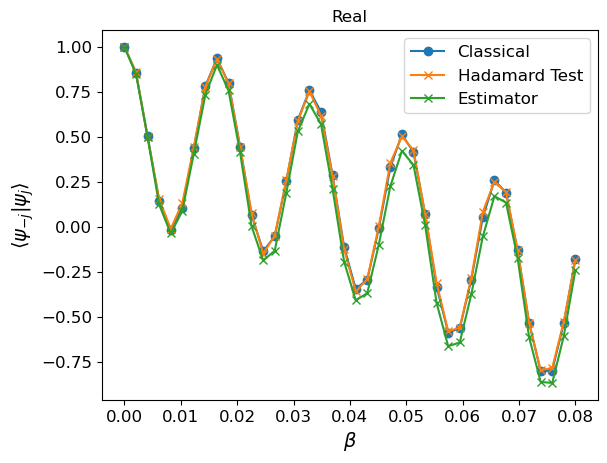

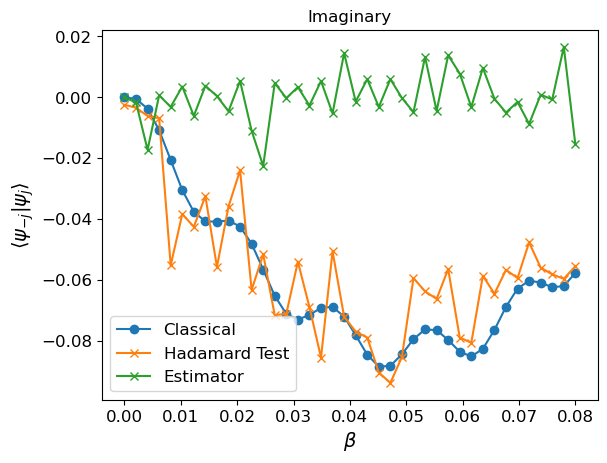

In [27]:
plt.figure(1)
plt.plot(betas, class_ovlp.real, 'o-', label='Classical')
plt.plot(betas, ovlps.real, 'x-', label='Hadamard Test')
plt.plot(betas, z.real, 'x-', label='Estimator')
plt.xlabel("$\\beta$")
plt.ylabel("$\\langle\\psi_{-j}|\\psi_j\\rangle$")
plt.title("Real")
plt.legend()


plt.figure(2)
plt.plot(betas, class_ovlp.imag, 'o-', label='Classical')
plt.plot(betas, ovlps.imag, 'x-', label='Hadamard Test')
plt.plot(betas, z.imag, 'x-', label='Estimator')
plt.xlabel("$\\beta$")
plt.ylabel("$\\langle\\psi_{-j}|\\psi_j\\rangle$")
plt.title("Imaginary")
plt.legend()

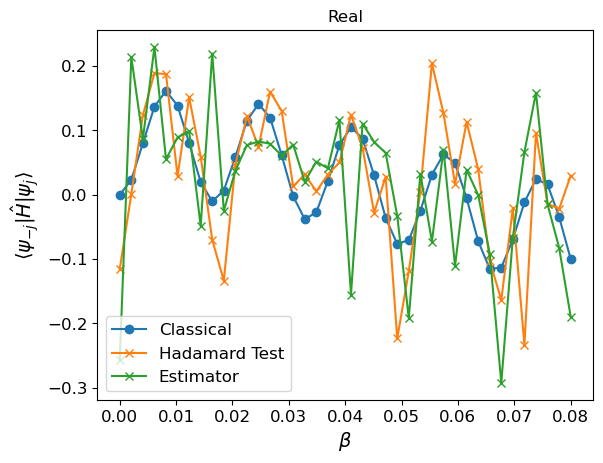

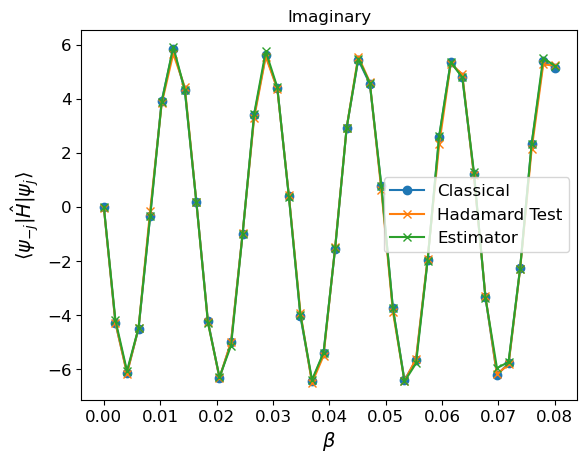

In [28]:
plt.figure(1)
plt.plot(betas, class_H_ovlp.real, 'o-', label='Classical')
plt.plot(betas, total_H_ovlp.real, 'x-', label='Hadamard Test')
plt.plot(betas, est_H_ovlp.real, 'x-', label='Estimator')
plt.xlabel("$\\beta$")
plt.ylabel("$\\langle\\psi_{-j}|\\hat{H}|\\psi_j\\rangle$")
plt.title("Real")
plt.legend()


plt.figure(2)
plt.plot(betas, class_H_ovlp.imag, 'o-', label='Classical')
plt.plot(betas, total_H_ovlp.imag, 'x-', label='Hadamard Test')
plt.plot(betas, est_H_ovlp.imag, 'x-', label='Estimator')
plt.xlabel("$\\beta$")
plt.ylabel("$\\langle\\psi_{-j}|\\hat{H}|\\psi_j\\rangle$")
plt.title("Imaginary")
plt.legend()

/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


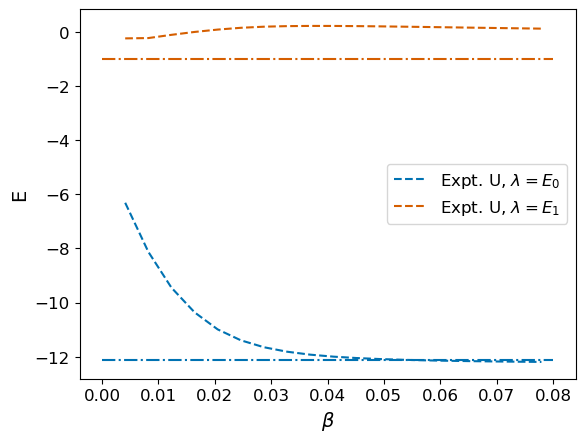

In [29]:
# first plot ground state
λ_0 = 1*E[0]
plt.plot(betas, E[0]*np.ones(len(betas)), '-.', color="#0072B2")
plt.plot(betas[2::2], stf.alt_partition_calc(z, est_H_ovlp, num_steps,
                                             1*λ_0, dt)[1][1:]-1*λ_0, '--', color="#0072B2",
                label='Expt. U, $\\lambda = E_0$')

# Now plot the first excited state
λ_1 = 1*E[2]
plt.plot(betas, E[2]*np.ones(len(betas)), '-.', color="#D55E00")
plt.plot(betas[2::2], stf.alt_partition_calc(z, est_H_ovlp, num_steps,
                                             λ_1, dt)[1][1:]-λ_1, '--', color="#D55E00",
                label='Expt. U, $\\lambda = E_1$')

plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()


## Fake Belem Noise Model Estimator

In [30]:
# Make a noise model
fake_backend = FakeBelem()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}
options.resilience_level = 0

In [31]:
z, O = expt_estimator(qr, H, num_steps, cliff, options)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 8)

In [ ]:
oth_z = z_re + z_im
plt.figure(1)
plt.plot(betas, oth_z.real, 'o-', label='Ideal')
plt.plot(betas, z.real, 'x-', label='Noise Model')
plt.legend()

plt.figure(2)
plt.plot(betas, oth_z.imag, 'o-', label='Ideal')
plt.plot(betas, z.imag, 'x-', label='Noise Model')
plt.legend()

plt.figure(3)
plt.title("H - Real")
plt.plot(betas, est_H_ovlp.real, 'o-', label='Ideal')
plt.plot(betas, O.real, 'x-', label='Noise Model')
plt.legend()

plt.figure(4)
plt.plot(betas, est_H_ovlp.imag, 'o-', label='Ideal')
plt.plot(betas, O.imag, 'x-', label='Noise Model')
plt.title("H - Imaginary")
plt.legend()

In [ ]:
# first plot ground state
λ_0 = 1*E[0]
plt.plot(betas, E[0]*np.ones(len(betas)), '-.', color="#0072B2")
plt.plot(betas[2::2], stf.alt_partition_calc(z, O, num_steps,
                                             1*λ_0, dt)[1][1:]-1*λ_0, '--', color="#0072B2",
                label='Expt. U, $\\lambda = E_0$')

# Now plot the first excited state
λ_1 = 1*E[2]
plt.plot(betas, E[2]*np.ones(len(betas)), '-.', color="#D55E00")
plt.plot(betas[2::2], stf.alt_partition_calc(z, O, num_steps,
                                             λ_1, dt)[1][1:]-λ_1, '--', color="#D55E00",
                label='Expt. U, $\\lambda = E_1$')

plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()